In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 14 - Multinomial processing trees

## 14.1 Multinomial processing model of pair-clustering
Multinomial processing trees (MPTs: Batchelder & Riefer, 1980, 1986; Chechile, 1973; Chechile & Meyer, 1976) provide one approach to modeling the finding that semantically related items are often recalled consecutively. An MPT model assumes that observed behavior arises from a sequence of cognitive events, able to be represented by a rooted tree architecture

$$ c,r,u \sim \text{Beta}(1,1)  $$
$$ \theta_{1} = cr $$
$$ \theta_{2} = (1\,-\,c)u^2 $$
$$ \theta_{3} = 2u\,(1\,-\,c)\,(1\,-\,u) $$
$$ \theta_{4} = c\,(1\,-\,r)\,+\,(1\,-\,c)\,(1\,-\,u)^2 $$
$$ \mathbf k \sim \text{Multinomial}(\mathbf \theta,n)$$

In [2]:
indiv_trial = {}
Nt = 3
kall = np.array([[45, 24, 97, 254],
              [106, 41, 107, 166],
              [243, 64, 65, 48]])
for trial in np.arange(Nt):
    k = kall[trial,:]
    n = sum(k)
    with pm.Model() as model1:
        c = pm.Beta("c",alpha=1,beta=1)
        r = pm.Beta("r",alpha=1,beta=1)
        u = pm.Beta("u",alpha=1,beta=1)
        
        t1 = c*r
        t2 = (1-c)*(u**2)
        t3 = 2*u*(1-c)*(1-u)
        t4 = c*(1-r)+(1-c)*(1-u)**2
        
        kobs = pm.Multinomial("kobs",p=[t1,t2,t3,t4],n=n,observed=k)
        trace = pm.sample(3e3, progressbar=False)
    
    # keep trace for later analysis
    indiv_trial[trial] = trace

Applied logodds-transform to c and added transformed c_logodds to model.
Applied logodds-transform to r and added transformed r_logodds to model.
Applied logodds-transform to u and added transformed u_logodds to model.
Assigned NUTS to c_logodds
Assigned NUTS to r_logodds
Assigned NUTS to u_logodds
Applied logodds-transform to c and added transformed c_logodds to model.
Applied logodds-transform to r and added transformed r_logodds to model.
Applied logodds-transform to u and added transformed u_logodds to model.
Assigned NUTS to c_logodds
Assigned NUTS to r_logodds
Assigned NUTS to u_logodds
Applied logodds-transform to c and added transformed c_logodds to model.
Applied logodds-transform to r and added transformed r_logodds to model.
Applied logodds-transform to u and added transformed u_logodds to model.
Assigned NUTS to c_logodds
Assigned NUTS to r_logodds
Assigned NUTS to u_logodds


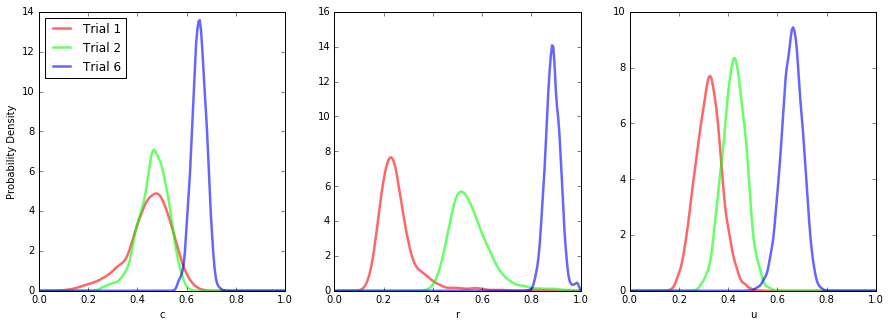

In [3]:
from scipy.stats.kde import gaussian_kde

fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,3)
x1=np.linspace(0, 1, 200)
plotparm=['c','r','u']
trialname=['Trial 1','Trial 2','Trial 6']
ax0 = {}
for trial in np.arange(Nt):
    colorvec=np.array([0,0,0])
    colorvec[trial]=1
    
    for ip, ii in enumerate(plotparm):
        cpost = indiv_trial[trial][ii][50:]
        ax0[ip] = plt.subplot(gs[ip])
        my_pdf = gaussian_kde(cpost)
        ax0[ip].plot(x1, my_pdf(x1),color=colorvec,lw=2.5, alpha=0.6) # distribution function
        plt.xlim([0,1])
        plt.xlabel(ii)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname,loc='upper left')
plt.ylabel('Probability Density')
plt.show()

## 14.2 Latent-trait MPT model

$$ \hat \mu^c, \hat \mu^r, \hat \mu^u \sim \text{Gaussian}(0,1)$$
$$ \hat \xi^c, \hat \xi^r, \hat \xi^u \sim \text{Uniform}(0,100)$$
$$ \Sigma^{-1} \sim \text{Wishart}(I,4)$$
$$ (\hat \delta_{i}^c,\hat \delta_{i}^r,\hat \delta_{i}^u) \sim \text{MvGaussian}(0,\Sigma^{-1})$$
$$ c_{i} = \Phi(\hat \mu^c\,+\,\hat \xi^c\hat \delta_{i}^c)$$
$$ r_{i} = \Phi(\hat \mu^r\,+\,\hat \xi^r\hat \delta_{i}^r)$$
$$ u_{i} = \Phi(\hat \mu^u\,+\,\hat \xi^u\hat \delta_{i}^u)$$
$$ \theta_{i1} = c_i r_i $$
$$ \theta_{i2} = (1\,-\,c_i)u_i^2 $$
$$ \theta_{i3} = 2u_i\,(1\,-\,c_i)\,(1\,-\,u_i) $$
$$ \theta_{i4} = c_i\,(1\,-\,r_i)\,+\,(1\,-\,c_i)\,(1\,-\,u_i)^2 $$
$$ \mathbf k_i \sim \text{Multinomial}(\mathbf \theta_i,n)$$

In [4]:
### Riefer et al (2002) data:
Nsubj = 21
Nitem = 20
response_1=np.array([2,4,4,10,2,1,3,14,2,2,5,11,6,0,4,10,1,
                     0,4,15,1,0,2,17,1,2,4,13,4,1,6,9,5,1,4,
                     10,1,0,9,10,5,0,3,12,0,1,6,13,1,5,7,7,1,
                     1,4,14,2,2,3,13,2,1,5,12,2,0,6,12,1,0,5,
                     14,2,1,8,9,3,0,2,15,1,2,3,14]).reshape(21,-1)
response_2=np.array([7,5,3,5,5,2,3,10,6,2,7,5,9,4,2,5,2,2,7,
                     9,1,3,3,13,5,0,5,10,7,3,4,6,7,3,6,4,4,1,
                     10,5,9,1,2,8,3,1,6,10,3,5,9,3,2,0,6,12,
                     8,0,3,9,3,2,7,8,7,1,5,7,2,1,6,11,5,3,5,
                     7,5,0,6,9,6,2,2,10]).reshape(21,-1)
response_6=np.array([14,3,1,2,12,3,1,4,18,0,1,1,15,3,0,2,7,
                     1,10,2,3,6,11,0,8,4,3,5,17,1,1,1,13,4,
                     3,0,11,6,1,2,16,1,2,1,10,1,3,6,7,13,0,
                     0,8,4,3,5,16,1,1,2,5,4,7,4,15,0,5,0,6,
                     3,6,5,17,2,0,1,17,1,0,2,8,3,6,3]).reshape(21,-1)
kall={}
kall[0] = response_1
kall[1] = response_2
kall[2] = response_6

In [5]:
indiv_trial2 = {}
Nt = 3
import scipy.stats

## Using Wishart prior
## Code steal from [Thomas Wiecki](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94639178)
def WishartBartlett(name, S, nu, is_cholesky=False, return_cholesky=False):
    """
    Bartlett decomposition of the Wishart distribution. As the Wishart
    distribution requires the matrix to be symmetric positive semi-definite
    it is impossible for MCMC to ever propose acceptable matrices.

    Instead, we can use the Barlett decomposition which samples a lower
    diagonal matrix. Specifically:

    If L ~ [[sqrt(c_1), 0, ...],
             [z_21, sqrt(c_2), 0, ...],
             [z_31, z32, sqrt(c_3), ...]]
    with c_i ~ Chi²(n-i+1) and n_ij ~ N(0, 1), then
    L * A * A.T * L.T ~ Wishart(L * L.T, nu)

    See http://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition
    for more information.

    :Parameters:
      S : ndarray
        p x p positive definite matrix
      nu : int
        Degrees of freedom, > dim(S).
      is_cholesky : bool (default=False)
        Input matrix S is already Cholesky decomposed as S.T * S
      return_cholesky : bool (default=False)
        Only return the Cholesky decomposed matrix.

    :Note:
      This is not a standard Distribution class but follows a similar
      interface. Besides, the Wishart distribution, it will add RVs 
      c and z to your model which make up the matrix.
    """

    L = S if is_cholesky else scipy.linalg.cholesky(S)

    diag_idx = np.diag_indices_from(S)
    tril_idx = np.tril_indices_from(S, k=-1)
    n_diag = len(diag_idx[0])
    n_tril = len(tril_idx[0])
    c1w = T.sqrt(pm.ChiSquared('c1w', nu - np.arange(1, n_diag+1) + 1, 
                               shape=n_diag,testval=np.ones(n_diag)))
    z1w = pm.Normal('z1w', 0, 1, shape=n_tril)
    # Construct A matrix
    A = T.zeros(S.shape, dtype=np.float32)
    A = T.set_subtensor(A[diag_idx], c1w)
    A = T.set_subtensor(A[tril_idx], z1w)

    # L * A * A.T * L.T ~ Wishart(L*L.T, nu)
    if return_cholesky:
        return pm.Deterministic(name, T.dot(L, A))
    else:
        return pm.Deterministic(name, T.dot(T.dot(T.dot(L, A), A.T), L.T))

In [6]:
p = 3
nu= p+1
for trial in np.arange(Nt):
    k = kall[trial]
    with pm.Model() as model2:
        mu = pm.Normal("mu",mu=0,sd=1,shape=p)
        xi = pm.Uniform("xi",lower=0,upper=100,shape=p)
        
        Sigmainv = WishartBartlett('Sigmainv', np.eye(p), nu)
        
        delta = pm.MvNormal("delta",mu=np.zeros(Nt),tau=Sigmainv,shape=(Nsubj,p))
        def Phi(x):
            # probit transform 
            return (1.0 + T.erf(x / np.sqrt(2.0))) / 2.0
        
        c = Phi(mu[0]+xi[0]*T.dot(delta,[1,0,0]))
        r = Phi(mu[1]+xi[1]*T.dot(delta,[0,1,0]))
        u = Phi(mu[2]+xi[2]*T.dot(delta,[0,0,1]))
        
        t1 = c*r
        t2 = (1-c)*(u**2)
        t3 = 2*u*(1-c)*(1-u)
        t4 = c*(1-r)+(1-c)*(1-u)**2
        
        muc=pm.Deterministic("muc",Phi(mu[0]))
        mur=pm.Deterministic("mur",Phi(mu[1]))
        muu=pm.Deterministic("muu",Phi(mu[2]))
        
        # kobs = pm.Multinomial("kobs",p=[t1,t2,t3,t4],n=Nitem,observed=k.T)
        # Multinomial data likelihood
        kobs = [pm.Multinomial('kobs_%i' % i, p = [t1[i],t2[i],t3[i],t4[i]], n=Nitem, 
                                     observed=k[i]) for i in np.arange(Nsubj)]
    
        trace = pm.sample(3e4, step=pm.Metropolis(), progressbar=False)
    
    # keep trace for later analysis
    indiv_trial2[trial] = trace

Applied interval-transform to xi and added transformed xi_interval to model.
Applied log-transform to c1w and added transformed c1w_log to model.
Applied interval-transform to xi and added transformed xi_interval to model.
Applied log-transform to c1w and added transformed c1w_log to model.
Applied interval-transform to xi and added transformed xi_interval to model.
Applied log-transform to c1w and added transformed c1w_log to model.


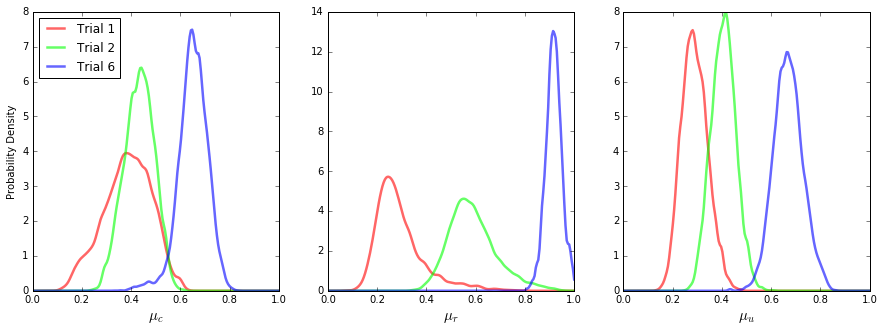

In [7]:
from scipy.stats.kde import gaussian_kde
import scipy.special as sp

fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,3)
x1=np.linspace(0, 1, 200)
plotparm=[r'$\mu_c$',r'$\mu_r$',r'$\mu_u$']
trialname=['Trial 1','Trial 2','Trial 6']
ax0 = {}

def npPhi(x):
    # probit transform 
    return (1.0 + sp.erf(x / np.sqrt(2.0))) / 2.0
        
for trial in np.arange(Nt):
    colorvec=np.array([0,0,0])
    colorvec[trial]=1
    mupost=indiv_trial2[trial]['mu'][50:]
    for ip, ii in enumerate(plotparm):
        cpost = npPhi(mupost[:,ip])
        ax0[ip] = plt.subplot(gs[ip])
        my_pdf = gaussian_kde(cpost)
        ax0[ip].plot(x1, my_pdf(x1),color=colorvec,lw=2.5, alpha=0.6) # distribution function
        plt.xlim([0,1])
        plt.xlabel(ii,fontsize=15)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname,loc='upper left')
plt.ylabel('Probability Density')
plt.show()

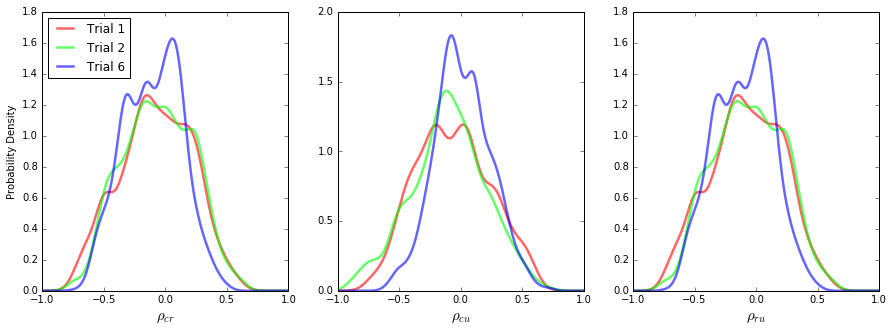

In [8]:
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,3)
x1=np.linspace(-1, 1, 200)
plotparm2=[r'$\rho_{cr}$',r'$\rho_{cu}$',r'$\rho_{ru}$']

for trial in np.arange(Nt):
    colorvec=np.array([0,0,0])
    colorvec[trial]=1
    
    sigmainvpost=indiv_trial2[trial]['Sigmainv'][1000:]
    sigmapost=np.ndarray((2000,3,3),dtype=float)
    for i in range(2000):
        sigmapost[i,:,:]=np.linalg.inv(sigmainvpost[i,:,:])
        
    cpost0 = sigmapost[:,0,1]/np.sqrt(sigmapost[:,0,0]*sigmapost[:,1,1])
    ax0 = plt.subplot(gs[0])
    my_pdf = gaussian_kde(cpost0)
    ax0.plot(x1, my_pdf(x1),color=colorvec,lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1,1])
    plt.xlabel(plotparm2[0],fontsize=15)
    
    cpost1 = sigmapost[:,0,2]/np.sqrt(sigmapost[:,0,0]*sigmapost[:,2,2])
    ax1 = plt.subplot(gs[1])
    my_pdf = gaussian_kde(cpost1)
    ax1.plot(x1, my_pdf(x1),color=colorvec,lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1,1])
    plt.xlabel(plotparm2[1],fontsize=15)
    
    cpost2 = sigmapost[:,1,2]/np.sqrt(sigmapost[:,1,1]*sigmapost[:,2,2])
    ax2 = plt.subplot(gs[2])
    my_pdf = gaussian_kde(cpost0)
    ax2.plot(x1, my_pdf(x1),color=colorvec,lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1,1])
    plt.xlabel(plotparm2[2],fontsize=15)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname,loc='upper left')
plt.ylabel('Probability Density')
plt.show()